<a href="https://colab.research.google.com/github/MinsooKwak/Detection/blob/main/Furniture_Detection/furniture_detection_yolov8.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Roboflow 설치**

Roboflow를 통해 데이터 라벨링, 증강을 활용할 수 있습니다.

데이터셋을 불러오기 위해 Roboflow를 설치합니다.

In [1]:
#!pip install roboflow

In [ ]:
!pip install ultralytics                              # YOLO 활용을 위해 ultralytics 설치

In [3]:
from roboflow import Roboflow
rf = Roboflow(api_key="LGy4rPnUu38hhcMqqByi")
project = rf.workspace("furniture-tngrl").project("furniture_detection-xw469")
#version = project.version(1)                         # 초기 데이터셋 miss 버전
version = project.version(2)                          # 데이터셋 재 구성 버전 (version2로 돌려주세요)
dataset = version.download("yolov8")

loading Roboflow workspace...
loading Roboflow project...
Dependency ultralytics==8.0.196 is required but found version=8.2.22, to fix: `pip install ultralytics==8.0.196`



Extracting Dataset Version Zip to furniture_detection-2 in yolov8:: 100%|██████████| 1390/1390 [00:00<00:00, 4286.56it/s]


**결과 설명 추가 (보완 대상)**

- 100 epoch 정도 돌렸을 때 결과는 `Sofa`, `Table`, `Chair` 클래스에 대한 각각의 AP값과 전체 mAP 결과가 나와야 함
- 현재 Validation 결과는 `Sofa`, `Table`에 대해서만 도출되었음
- 아래 Test 결과에서는 `Chair`와 `Sofa`에 대해서 나왔는데,
  Train, Val, Test셋 자체의 구성이 고르게 나뉜 것이 아니라 Validation 데이터 자체에 `Chair` 클래스가 누락되었고, Test 데이터 자체에 `Table` 데이터가 누락되었기 때문이었음
- 이를 보완하기 위해 Train, Val, Test 데이터셋에서 각각의 클래스 분포를 조정해 다시 결과를 도출할 예정

- Validation 결과

  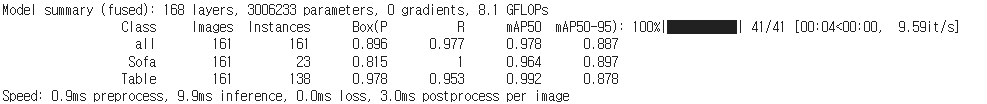

- 아래 Test셋 결과
  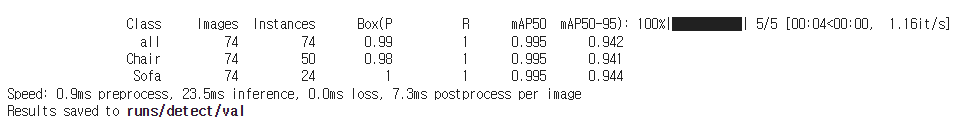

**데이터셋 비율 수정**

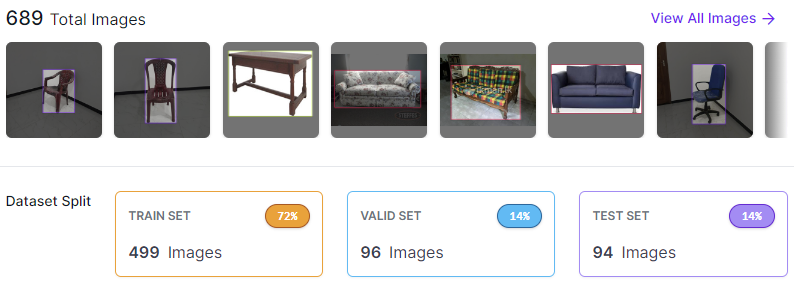

In [4]:
import os
import random
import pandas as pd
from PIL import Image
import cv2
from IPython.display import Video
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pathlib
import glob
from tqdm.notebook import trange, tqdm
import warnings
warnings.filterwarnings('ignore')

이미지 예시 확인해보기

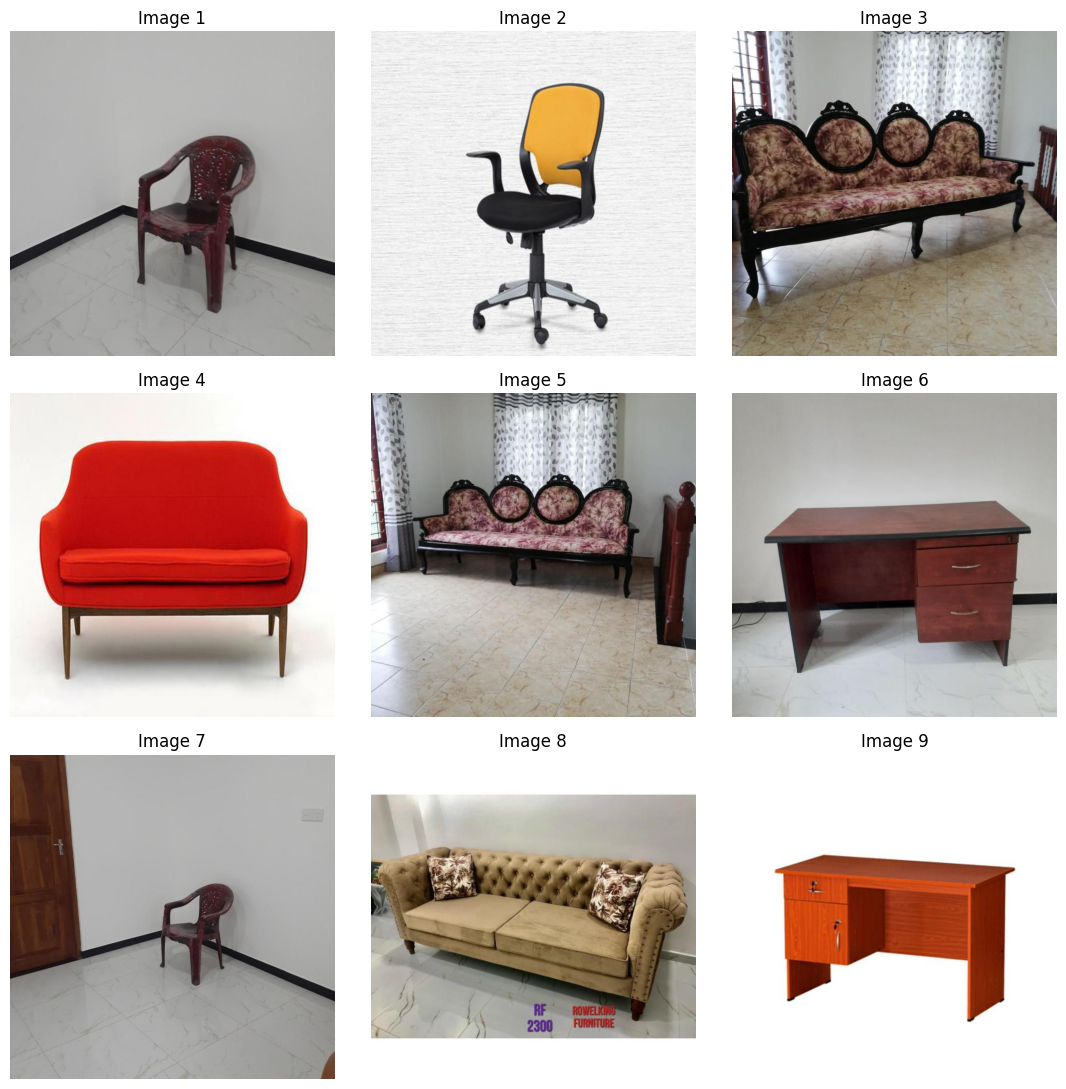

In [5]:
Image_dir = '/content/furniture_detection-2/train/images'

num_samples=9                                               # 9개만 확인
image_files = os.listdir(Image_dir)                         # Image_dir에서 불러와 확인해보기

rand_images = random.sample(image_files, num_samples)       # 랜덤으로 골라 확인하기

fig, axes = plt.subplots(3,3, figsize=(11,11))              # 3x3 서브 플랏 구성

for i in range(num_samples):                                # 9개 샘플까지 순서대로
  image = rand_images[i]                                    # i번째 이미지
  ax = axes[i //3, i%3]                                     # 3 x 3 서브 플랏에 순서대로 배치
  ax.imshow(plt.imread(os.path.join(Image_dir, image)))     # 읽어서 시각화
  ax.set_title(f'Image {i+1}')                              # 제목 설정
  ax.axis('off')                                            # 축 없애기

plt.tight_layout()
plt.show()

In [6]:
# YOLO 활용을 위해 라이브러리 임포트
from ultralytics import YOLO

In [7]:
detection_model = YOLO('yolov8n.pt').load('yolov8n.pt')     # 탐지를 위해 YOLO 모델 불러오기

100%|██████████| 6.23M/6.23M [00:00<00:00, 112MB/s]


Transferred 355/355 items from pretrained weights



image 1/1 /content/furniture_detection-2/test/images/Chair-269-_jpg.rf.acc202ee7bd2d30964bcb23266e6ed13.jpg: 640x640 1 chair, 16.6ms
Speed: 7.1ms preprocess, 16.6ms inference, 3123.5ms postprocess per image at shape (1, 3, 640, 640)


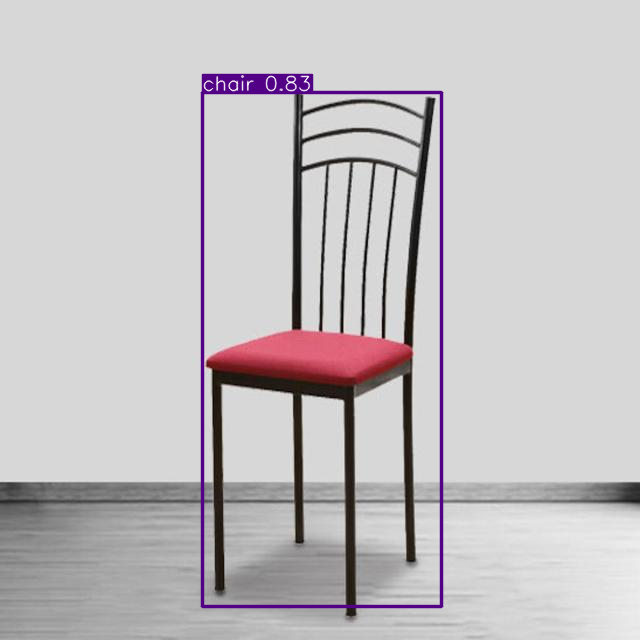

In [8]:
# 학습 전 YOLO base 모델로 확인해보기
image_pre = "/content/furniture_detection-2/test/images/Chair-269-_jpg.rf.acc202ee7bd2d30964bcb23266e6ed13.jpg"
result_predict = detection_model.predict(source=image_pre, imgsz=640)             # 현재 데이터셋의 크기를 640x640으로 설정해 구성했기 때문에 640 크기로 확인

plot = result_predict[0].plot()
plot = cv2.cvtColor(plot, cv2.COLOR_BGR2RGB)                                      # cv2는 B2R로 구성되어 RGB로 바꿔 출력
display(Image.fromarray(plot))

In [9]:
#num_classes = 3
#classes = ['Chair','Sofa','Table']

**YOLO 학습을 위해 yaml 파일 만들기**

In [10]:
text = """
train: /content/furniture_detection-2/train       # train 데이터 경로
val: /content/furniture_detection-2/valid         # validation 데이터 경로
test: /content/furniture_detection-2/test         # test 데이터 경로

# number of classes
nc: 3

# class names
names: ['Chair','Sofa','Table']
"""

with open('data.yaml','w') as file:
  file.write(text)

데이터셋의 구성 클래스는 `Chair`, `Sofa`, `Table` 총 3개의 클래스 입니다.

## Train

In [11]:
Result_Final_model=detection_model.train(data='data.yaml',        # 불러온 YOLO 모델을 저장한 detection_model을 통해 학습 # yaml 내부 정보 참고해 학습 진행
                                         epochs=100,              # 100번 돌림
                                         imgsz=640,               # 이미지 사이즈 640으로 설정해 640으로 학습
                                         batch=2,                 # 2개씩 학습
                                         lr0=0.001,               # learning rate 0.001
                                         dropout=0.2,             # 20%는 랜덤으로 버리고 학습 (과적합 방지)
                                         device=1                 # gpu 활용해 돌림 (미활용시 0)
                                         )

Ultralytics YOLOv8.2.22 🚀 Python-3.10.12 torch-2.3.0+cu121 CUDA:1 (Tesla T4, 15102MiB)
engine/trainer: task=detect, mode=train, model=yolov8n.pt, data=data.yaml, epochs=100, time=None, patience=100, batch=2, imgsz=640, save=True, save_period=-1, cache=False, device=1, workers=8, project=None, name=train, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.2, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, show_conf=True, show_boxes=True, line_wid

100%|██████████| 755k/755k [00:00<00:00, 24.8MB/s]


Overriding model.yaml nc=80 with nc=3

                   from  n    params  module                                       arguments                     
  0                  -1  1       464  ultralytics.nn.modules.conv.Conv             [3, 16, 3, 2]                 
  1                  -1  1      4672  ultralytics.nn.modules.conv.Conv             [16, 32, 3, 2]                
  2                  -1  1      7360  ultralytics.nn.modules.block.C2f             [32, 32, 1, True]             
  3                  -1  1     18560  ultralytics.nn.modules.conv.Conv             [32, 64, 3, 2]                
  4                  -1  2     49664  ultralytics.nn.modules.block.C2f             [64, 64, 2, True]             
  5                  -1  1     73984  ultralytics.nn.modules.conv.Conv             [64, 128, 3, 2]               
  6                  -1  2    197632  ultralytics.nn.modules.block.C2f             [128, 128, 2, True]           
  7                  -1  1    295424  ultralytics

train: Scanning /content/furniture_detection-2/train/labels... 499 images, 0 backgrounds, 0 corrupt: 100%|██████████| 499/499 [00:00<00:00, 671.57it/s]


train: New cache created: /content/furniture_detection-2/train/labels.cache
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))


val: Scanning /content/furniture_detection-2/valid/labels... 96 images, 0 backgrounds, 0 corrupt: 100%|██████████| 96/96 [00:00<00:00, 572.59it/s]

val: New cache created: /content/furniture_detection-2/valid/labels.cache


Plotting labels to runs/detect/train/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.001' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.001429, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 640 train, 640 val
Using 2 dataloader workers
Logging results to runs/detect/train
Starting training for 100 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      1/100     0.669G      2.185      3.108      2.226          1        640: 100%|██████████| 250/250 [00:33<00:00,  7.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [00:05<00:00,  4.45it/s]

                   all         96         96      0.396       0.77      0.555       0.28



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      2/100     0.487G      1.324      2.172      1.681          1        640: 100%|██████████| 250/250 [00:31<00:00,  7.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [00:01<00:00, 13.31it/s]

                   all         96         96      0.572      0.802      0.863      0.576



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      3/100     0.499G      1.137      1.838      1.556          4        640: 100%|██████████| 250/250 [00:37<00:00,  6.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [00:01<00:00, 17.49it/s]

                   all         96         96      0.672      0.807      0.822      0.522



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      4/100     0.499G      1.033      1.602      1.483          3        640: 100%|██████████| 250/250 [00:26<00:00,  9.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [00:01<00:00, 17.35it/s]

                   all         96         96      0.867      0.815      0.893      0.673



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      5/100     0.499G     0.9603      1.448      1.425          1        640: 100%|██████████| 250/250 [00:26<00:00,  9.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [00:02<00:00, 11.28it/s]

                   all         96         96      0.925      0.887      0.943      0.742



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      6/100     0.499G     0.9025      1.327      1.384          3        640: 100%|██████████| 250/250 [00:28<00:00,  8.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [00:01<00:00, 14.36it/s]


                   all         96         96      0.936      0.917       0.98       0.75

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      7/100     0.499G     0.8934      1.233      1.356          1        640: 100%|██████████| 250/250 [00:28<00:00,  8.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [00:01<00:00, 16.70it/s]

                   all         96         96      0.863      0.956      0.973      0.774



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      8/100     0.499G     0.8898      1.207      1.356          1        640: 100%|██████████| 250/250 [00:37<00:00,  6.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [00:02<00:00, 11.75it/s]

                   all         96         96      0.927      0.803      0.929      0.731



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      9/100     0.499G       0.82      1.113      1.299          2        640: 100%|██████████| 250/250 [00:28<00:00,  8.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [00:01<00:00, 17.22it/s]

                   all         96         96      0.884      0.908      0.962        0.8



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     10/100     0.499G     0.8492      1.067       1.33          2        640: 100%|██████████| 250/250 [00:27<00:00,  9.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [00:02<00:00,  9.95it/s]

                   all         96         96       0.94      0.852      0.959      0.782



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     11/100     0.499G     0.8185     0.9902      1.292          1        640: 100%|██████████| 250/250 [00:28<00:00,  8.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [00:01<00:00, 15.96it/s]

                   all         96         96      0.921      0.938      0.954      0.797



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     12/100     0.499G     0.7542     0.9147       1.26          3        640: 100%|██████████| 250/250 [00:27<00:00,  9.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [00:01<00:00, 16.64it/s]

                   all         96         96      0.921      0.948      0.974       0.81



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     13/100     0.499G     0.7139     0.8504      1.236          2        640: 100%|██████████| 250/250 [00:31<00:00,  8.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [00:01<00:00, 17.82it/s]

                   all         96         96      0.744      0.851      0.947      0.777



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     14/100     0.499G     0.7435      0.833      1.246          2        640: 100%|██████████| 250/250 [00:27<00:00,  9.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [00:01<00:00, 13.55it/s]

                   all         96         96      0.921      0.828      0.931      0.735



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     15/100     0.499G     0.7349      0.871      1.239          2        640: 100%|██████████| 250/250 [00:26<00:00,  9.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [00:02<00:00, 10.22it/s]

                   all         96         96      0.893      0.971      0.973      0.814



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     16/100     0.499G     0.7358     0.8388      1.241          2        640: 100%|██████████| 250/250 [00:32<00:00,  7.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [00:02<00:00, 10.44it/s]

                   all         96         96       0.94      0.779      0.946      0.793



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     17/100     0.499G     0.6851     0.8083      1.204          4        640: 100%|██████████| 250/250 [00:29<00:00,  8.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [00:01<00:00, 15.29it/s]

                   all         96         96      0.928      0.894      0.964      0.798



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     18/100     0.499G     0.7336     0.8045      1.248          3        640: 100%|██████████| 250/250 [00:33<00:00,  7.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [00:02<00:00,  9.23it/s]

                   all         96         96      0.944      0.896      0.939      0.799



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     19/100     0.499G     0.6479     0.7298      1.171          1        640: 100%|██████████| 250/250 [00:41<00:00,  5.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [00:01<00:00, 17.67it/s]

                   all         96         96      0.949      0.887      0.933      0.782



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     20/100     0.499G     0.6681     0.7123      1.175          2        640: 100%|██████████| 250/250 [00:25<00:00,  9.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [00:02<00:00,  9.34it/s]

                   all         96         96      0.928      0.903      0.968      0.824



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     21/100     0.499G     0.6662     0.7173      1.178          2        640: 100%|██████████| 250/250 [00:38<00:00,  6.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [00:01<00:00, 15.84it/s]

                   all         96         96      0.935      0.983      0.978      0.862



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     22/100     0.499G      0.663     0.6823      1.179          1        640: 100%|██████████| 250/250 [00:38<00:00,  6.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [00:01<00:00, 17.01it/s]

                   all         96         96      0.991      0.887      0.977      0.834



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     23/100     0.499G     0.6528     0.6877      1.177          1        640: 100%|██████████| 250/250 [00:26<00:00,  9.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [00:01<00:00, 17.45it/s]

                   all         96         96      0.917      0.937      0.983      0.823



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     24/100     0.499G     0.6471     0.6648      1.196          1        640: 100%|██████████| 250/250 [00:27<00:00,  9.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [00:03<00:00,  7.31it/s]

                   all         96         96      0.903      0.961      0.973      0.807



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     25/100     0.499G     0.6376     0.6503      1.166          2        640: 100%|██████████| 250/250 [00:33<00:00,  7.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [00:03<00:00,  7.05it/s]

                   all         96         96      0.753      0.943      0.959      0.831



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     26/100     0.499G     0.6283     0.6912      1.157          2        640: 100%|██████████| 250/250 [00:30<00:00,  8.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [00:02<00:00, 11.83it/s]

                   all         96         96      0.839      0.948      0.965       0.81



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     27/100     0.499G     0.6128     0.6693      1.149          1        640: 100%|██████████| 250/250 [00:25<00:00,  9.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [00:01<00:00, 12.62it/s]

                   all         96         96      0.933      0.988      0.982      0.858



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     28/100     0.499G     0.6314     0.6626      1.176          4        640: 100%|██████████| 250/250 [00:36<00:00,  6.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [00:02<00:00,  8.64it/s]

                   all         96         96      0.937      0.922      0.972      0.848



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     29/100     0.499G     0.6083     0.6088      1.149          2        640: 100%|██████████| 250/250 [00:34<00:00,  7.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [00:02<00:00,  8.08it/s]

                   all         96         96      0.817      0.909      0.932      0.786



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     30/100     0.499G     0.5973     0.6117      1.151          4        640: 100%|██████████| 250/250 [00:36<00:00,  6.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [00:02<00:00,  9.15it/s]

                   all         96         96      0.948      0.989      0.979      0.844



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     31/100     0.499G      0.618     0.5982       1.14          1        640: 100%|██████████| 250/250 [00:36<00:00,  6.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [00:02<00:00, 11.52it/s]

                   all         96         96      0.877      0.954      0.971      0.842



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     32/100     0.499G     0.6099     0.6068      1.136          2        640: 100%|██████████| 250/250 [00:31<00:00,  7.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [00:01<00:00, 17.33it/s]

                   all         96         96      0.765      0.925      0.958      0.824



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     33/100     0.499G      0.564     0.6197      1.118          2        640: 100%|██████████| 250/250 [00:27<00:00,  8.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [00:03<00:00,  6.23it/s]

                   all         96         96       0.94      0.988       0.99      0.862



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     34/100     0.499G     0.5873     0.5999      1.131          4        640: 100%|██████████| 250/250 [00:27<00:00,  9.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [00:02<00:00, 11.55it/s]


                   all         96         96      0.868      0.913      0.988      0.867

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     35/100     0.499G     0.5535      0.557      1.098          2        640: 100%|██████████| 250/250 [00:29<00:00,  8.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [00:01<00:00, 16.22it/s]

                   all         96         96      0.984      0.975      0.991       0.86



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     36/100     0.499G     0.5726      0.555      1.118          3        640: 100%|██████████| 250/250 [00:26<00:00,  9.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [00:01<00:00, 18.55it/s]

                   all         96         96      0.934      0.987      0.989      0.866



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     37/100     0.499G     0.5758     0.5436       1.12          2        640: 100%|██████████| 250/250 [00:26<00:00,  9.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [00:01<00:00, 14.78it/s]

                   all         96         96      0.941      0.927      0.978      0.874



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     38/100     0.499G     0.5577     0.5332       1.12          2        640: 100%|██████████| 250/250 [00:24<00:00, 10.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [00:01<00:00, 15.89it/s]

                   all         96         96      0.886       0.96      0.972      0.853



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     39/100     0.499G     0.5789     0.5764      1.118          1        640: 100%|██████████| 250/250 [00:27<00:00,  9.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [00:01<00:00, 12.10it/s]

                   all         96         96      0.929       0.95      0.985      0.865



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     40/100     0.499G     0.5491     0.5362      1.123          1        640: 100%|██████████| 250/250 [00:30<00:00,  8.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [00:01<00:00, 17.04it/s]

                   all         96         96      0.921      0.939      0.987      0.862



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     41/100     0.499G     0.5562     0.5507       1.11          1        640: 100%|██████████| 250/250 [00:26<00:00,  9.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [00:01<00:00, 17.02it/s]

                   all         96         96      0.911      0.979      0.985      0.893



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     42/100     0.499G     0.5379     0.5425      1.102          2        640: 100%|██████████| 250/250 [00:24<00:00, 10.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [00:01<00:00, 14.37it/s]

                   all         96         96      0.919      0.972      0.983      0.863



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     43/100     0.499G     0.5803     0.5261      1.132          4        640: 100%|██████████| 250/250 [00:25<00:00,  9.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [00:01<00:00, 17.69it/s]

                   all         96         96      0.909      0.979      0.987      0.879



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     44/100     0.499G     0.5495     0.5305      1.107          1        640: 100%|██████████| 250/250 [00:27<00:00,  9.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [00:01<00:00, 13.08it/s]

                   all         96         96      0.936      0.977      0.985      0.886



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     45/100     0.499G      0.549     0.5342      1.104          2        640: 100%|██████████| 250/250 [00:24<00:00, 10.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [00:01<00:00, 18.39it/s]

                   all         96         96      0.891      0.993      0.985      0.877



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     46/100     0.499G     0.5459     0.5477      1.126          2        640: 100%|██████████| 250/250 [00:26<00:00,  9.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [00:01<00:00, 17.53it/s]

                   all         96         96      0.938      0.985      0.989      0.901



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     47/100     0.499G     0.5611     0.5177      1.118          1        640: 100%|██████████| 250/250 [00:26<00:00,  9.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [00:01<00:00, 15.90it/s]

                   all         96         96      0.954       0.97      0.987        0.9



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     48/100     0.499G     0.5531      0.511      1.105          4        640: 100%|██████████| 250/250 [00:24<00:00, 10.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [00:01<00:00, 13.81it/s]


                   all         96         96      0.866       0.96      0.978       0.85

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     49/100     0.499G     0.5363     0.5007      1.106          1        640: 100%|██████████| 250/250 [00:26<00:00,  9.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [00:01<00:00, 17.46it/s]

                   all         96         96       0.93      0.965      0.988      0.888



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     50/100     0.499G     0.5298     0.4864      1.097          4        640: 100%|██████████| 250/250 [00:27<00:00,  9.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [00:01<00:00, 14.43it/s]

                   all         96         96      0.915      0.965      0.982       0.89



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     51/100     0.499G     0.5236     0.4833      1.072          2        640: 100%|██████████| 250/250 [00:24<00:00, 10.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [00:01<00:00, 13.79it/s]

                   all         96         96      0.943      0.938      0.983      0.872



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     52/100     0.499G     0.5491     0.5096       1.11          1        640: 100%|██████████| 250/250 [00:30<00:00,  8.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [00:01<00:00, 17.16it/s]

                   all         96         96      0.951      0.983       0.99       0.86



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     53/100     0.499G     0.5052     0.5042      1.075          1        640: 100%|██████████| 250/250 [00:28<00:00,  8.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [00:01<00:00, 17.90it/s]

                   all         96         96      0.955      0.983      0.989      0.882



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     54/100     0.499G     0.5264     0.5383      1.083          0        640: 100%|██████████| 250/250 [00:27<00:00,  9.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [00:01<00:00, 17.14it/s]

                   all         96         96      0.948      0.981       0.99      0.894



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     55/100     0.499G     0.5346     0.5099      1.101          1        640: 100%|██████████| 250/250 [00:27<00:00,  8.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [00:04<00:00,  5.27it/s]

                   all         96         96      0.954      0.952      0.994      0.881



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     56/100     0.499G     0.5084     0.4787      1.073          3        640: 100%|██████████| 250/250 [00:26<00:00,  9.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [00:01<00:00, 12.10it/s]

                   all         96         96      0.927      0.956      0.979      0.873



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     57/100     0.499G     0.4994     0.4638      1.072          4        640: 100%|██████████| 250/250 [00:25<00:00,  9.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [00:01<00:00, 17.36it/s]

                   all         96         96      0.935      0.971      0.988      0.884



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     58/100     0.499G      0.503     0.4481      1.076          2        640: 100%|██████████| 250/250 [00:27<00:00,  9.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [00:01<00:00, 18.08it/s]

                   all         96         96       0.93      0.979      0.986       0.88



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     59/100     0.499G     0.5002     0.4589      1.069          2        640: 100%|██████████| 250/250 [00:26<00:00,  9.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [00:02<00:00,  9.52it/s]

                   all         96         96      0.941      0.983      0.988      0.876



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     60/100     0.499G      0.517     0.4528      1.078          2        640: 100%|██████████| 250/250 [00:32<00:00,  7.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [00:03<00:00,  7.12it/s]

                   all         96         96      0.936       0.99      0.987      0.902



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     61/100     0.499G     0.4936     0.4578      1.066          1        640: 100%|██████████| 250/250 [00:24<00:00, 10.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [00:01<00:00, 18.02it/s]

                   all         96         96      0.948      0.987      0.989      0.894



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     62/100     0.499G     0.4891     0.4466      1.069          2        640: 100%|██████████| 250/250 [00:33<00:00,  7.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [00:01<00:00, 17.74it/s]

                   all         96         96      0.948      0.972      0.989      0.903



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     63/100     0.499G     0.5072     0.4642      1.079          4        640: 100%|██████████| 250/250 [00:29<00:00,  8.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [00:01<00:00, 12.10it/s]

                   all         96         96      0.925      0.974      0.981      0.881



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     64/100     0.499G      0.483     0.4392      1.063          2        640: 100%|██████████| 250/250 [00:32<00:00,  7.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [00:01<00:00, 17.53it/s]

                   all         96         96       0.94      0.982      0.968      0.863



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     65/100     0.499G     0.5024     0.4694       1.08          2        640: 100%|██████████| 250/250 [00:31<00:00,  7.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [00:01<00:00, 18.55it/s]

                   all         96         96      0.945      0.988      0.986      0.873



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     66/100     0.499G     0.4838     0.4441      1.062          1        640: 100%|██████████| 250/250 [00:30<00:00,  8.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [00:01<00:00, 17.57it/s]

                   all         96         96      0.952      0.985      0.987      0.914



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     67/100     0.499G     0.4807      0.437      1.077          1        640: 100%|██████████| 250/250 [00:29<00:00,  8.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [00:01<00:00, 18.13it/s]

                   all         96         96      0.947      0.984      0.978      0.891



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     68/100     0.499G     0.4767     0.4369       1.05          2        640: 100%|██████████| 250/250 [00:24<00:00, 10.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [00:02<00:00, 10.39it/s]

                   all         96         96      0.949      0.983      0.987      0.884



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     69/100     0.499G      0.483     0.4327      1.066          3        640: 100%|██████████| 250/250 [00:25<00:00,  9.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [00:01<00:00, 17.21it/s]

                   all         96         96      0.936      0.977      0.991      0.892



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     70/100     0.499G     0.4771     0.4278      1.061          1        640: 100%|██████████| 250/250 [00:27<00:00,  9.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [00:01<00:00, 18.14it/s]

                   all         96         96      0.951      0.977      0.987      0.913



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     71/100     0.499G      0.479     0.4184      1.064          2        640: 100%|██████████| 250/250 [00:24<00:00, 10.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [00:02<00:00, 11.27it/s]


                   all         96         96      0.949       0.99       0.97      0.884

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     72/100     0.499G     0.4641     0.4226      1.053          1        640: 100%|██████████| 250/250 [00:28<00:00,  8.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [00:01<00:00, 18.01it/s]

                   all         96         96      0.914      0.986      0.984      0.888



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     73/100     0.499G     0.4606     0.4139      1.053          3        640: 100%|██████████| 250/250 [00:29<00:00,  8.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [00:01<00:00, 17.61it/s]

                   all         96         96      0.944      0.993      0.975      0.897



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     74/100     0.499G       0.44     0.3831       1.03          3        640: 100%|██████████| 250/250 [00:27<00:00,  9.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [00:01<00:00, 14.99it/s]

                   all         96         96      0.949      0.993      0.988      0.914



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     75/100     0.499G      0.456     0.3848       1.05          1        640: 100%|██████████| 250/250 [00:24<00:00, 10.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [00:01<00:00, 16.29it/s]


                   all         96         96       0.94      0.994      0.988       0.91

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     76/100     0.499G     0.4466     0.4037      1.052          1        640: 100%|██████████| 250/250 [00:27<00:00,  9.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [00:01<00:00, 17.99it/s]

                   all         96         96      0.943      0.979      0.988      0.901



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     77/100     0.499G     0.4579     0.4086      1.059          2        640: 100%|██████████| 250/250 [00:27<00:00,  9.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [00:01<00:00, 15.27it/s]

                   all         96         96      0.944      0.989      0.988      0.901



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     78/100     0.499G     0.4805     0.4348      1.068          4        640: 100%|██████████| 250/250 [00:24<00:00, 10.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [00:01<00:00, 12.35it/s]

                   all         96         96      0.952      0.994      0.984      0.901



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     79/100     0.499G     0.4556     0.3963      1.054          4        640: 100%|██████████| 250/250 [00:26<00:00,  9.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [00:01<00:00, 17.56it/s]

                   all         96         96      0.952      0.994      0.989      0.919



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     80/100     0.499G      0.429     0.3966      1.027          1        640: 100%|██████████| 250/250 [00:27<00:00,  8.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [00:01<00:00, 18.03it/s]

                   all         96         96      0.954      0.994      0.985      0.913



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     81/100     0.499G     0.4572     0.3903       1.04          2        640: 100%|██████████| 250/250 [00:28<00:00,  8.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [00:02<00:00, 10.67it/s]

                   all         96         96       0.95      0.994      0.983      0.904



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     82/100     0.499G      0.459     0.3782      1.064          4        640: 100%|██████████| 250/250 [00:24<00:00, 10.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [00:01<00:00, 17.86it/s]

                   all         96         96       0.95      0.994      0.979        0.9



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     83/100     0.499G     0.4442     0.3824      1.052          1        640: 100%|██████████| 250/250 [00:27<00:00,  8.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [00:01<00:00, 17.95it/s]

                   all         96         96      0.949      0.994      0.984        0.9



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     84/100     0.499G     0.4329     0.3746      1.041          1        640: 100%|██████████| 250/250 [00:26<00:00,  9.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [00:01<00:00, 13.21it/s]

                   all         96         96      0.946       0.99      0.988      0.905



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     85/100     0.499G     0.4376     0.3945      1.022          0        640: 100%|██████████| 250/250 [00:24<00:00, 10.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [00:02<00:00, 11.83it/s]

                   all         96         96      0.948      0.989      0.984      0.922



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     86/100     0.499G     0.4503      0.386      1.044          2        640: 100%|██████████| 250/250 [00:25<00:00,  9.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [00:01<00:00, 16.88it/s]

                   all         96         96      0.947      0.994      0.988      0.917



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     87/100     0.499G     0.4605     0.4104      1.053          2        640: 100%|██████████| 250/250 [00:27<00:00,  8.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [00:01<00:00, 17.49it/s]

                   all         96         96      0.952      0.993      0.988      0.927



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     88/100     0.499G     0.4288     0.3829       1.03          2        640: 100%|██████████| 250/250 [00:25<00:00,  9.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [00:02<00:00, 10.86it/s]

                   all         96         96      0.952      0.991      0.989      0.929



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     89/100     0.499G     0.4321     0.3872      1.015          1        640: 100%|██████████| 250/250 [00:25<00:00,  9.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [00:01<00:00, 17.15it/s]

                   all         96         96      0.953      0.991      0.989      0.927



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     90/100     0.499G     0.4417      0.384      1.043          4        640: 100%|██████████| 250/250 [00:27<00:00,  9.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [00:01<00:00, 18.19it/s]

                   all         96         96       0.95      0.991      0.988      0.927


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     91/100     0.499G     0.3015     0.2666     0.9533          1        640: 100%|██████████| 250/250 [00:25<00:00,  9.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [00:02<00:00, 11.15it/s]

                   all         96         96      0.952      0.994      0.988       0.92



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     92/100     0.499G     0.2807     0.2464     0.9215          1        640: 100%|██████████| 250/250 [00:25<00:00,  9.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [00:01<00:00, 17.14it/s]

                   all         96         96      0.953      0.994      0.987      0.931



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     93/100     0.499G     0.2778     0.2435     0.9232          1        640: 100%|██████████| 250/250 [00:28<00:00,  8.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [00:01<00:00, 14.22it/s]

                   all         96         96      0.952      0.989      0.987      0.933



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     94/100     0.497G     0.2905     0.2527     0.9391          1        640: 100%|██████████| 250/250 [00:24<00:00, 10.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [00:01<00:00, 13.58it/s]

                   all         96         96      0.952      0.987      0.987       0.93



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     95/100     0.499G     0.2724     0.2389     0.9273          1        640: 100%|██████████| 250/250 [00:26<00:00,  9.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [00:01<00:00, 17.48it/s]

                   all         96         96      0.953      0.994      0.988      0.933



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     96/100     0.497G     0.2761     0.2418     0.9197          1        640: 100%|██████████| 250/250 [00:28<00:00,  8.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [00:01<00:00, 17.81it/s]

                   all         96         96      0.948      0.989      0.987      0.928



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     97/100     0.499G     0.2734     0.2367     0.9212          1        640: 100%|██████████| 250/250 [00:24<00:00, 10.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [00:02<00:00, 10.37it/s]

                   all         96         96      0.952       0.99      0.987      0.926



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     98/100     0.497G     0.2672     0.2309     0.9188          1        640: 100%|██████████| 250/250 [00:25<00:00,  9.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [00:01<00:00, 17.30it/s]

                   all         96         96      0.952       0.99      0.989      0.917



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     99/100     0.499G     0.2648     0.2294      0.914          1        640: 100%|██████████| 250/250 [00:27<00:00,  9.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [00:01<00:00, 17.64it/s]

                   all         96         96      0.952      0.994      0.988       0.93



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    100/100     0.499G     0.2655     0.2266     0.9064          1        640: 100%|██████████| 250/250 [00:27<00:00,  9.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [00:01<00:00, 17.74it/s]

                   all         96         96      0.952       0.99      0.988      0.924



100 epochs completed in 0.865 hours.
Optimizer stripped from runs/detect/train/weights/last.pt, 6.3MB
Optimizer stripped from runs/detect/train/weights/best.pt, 6.3MB

Validating runs/detect/train/weights/best.pt...
Ultralytics YOLOv8.2.22 🚀 Python-3.10.12 torch-2.3.0+cu121 CUDA:1 (Tesla T4, 15102MiB)
Model summary (fused): 168 layers, 3006233 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [00:01<00:00, 14.84it/s]


                   all         96         96      0.953      0.994      0.988      0.934
                  Sofa         96         10      0.906          1      0.986      0.965
                 Table         96         86      0.999      0.988      0.991      0.902
Speed: 0.8ms preprocess, 5.6ms inference, 0.0ms loss, 1.4ms postprocess per image
Results saved to runs/detect/train


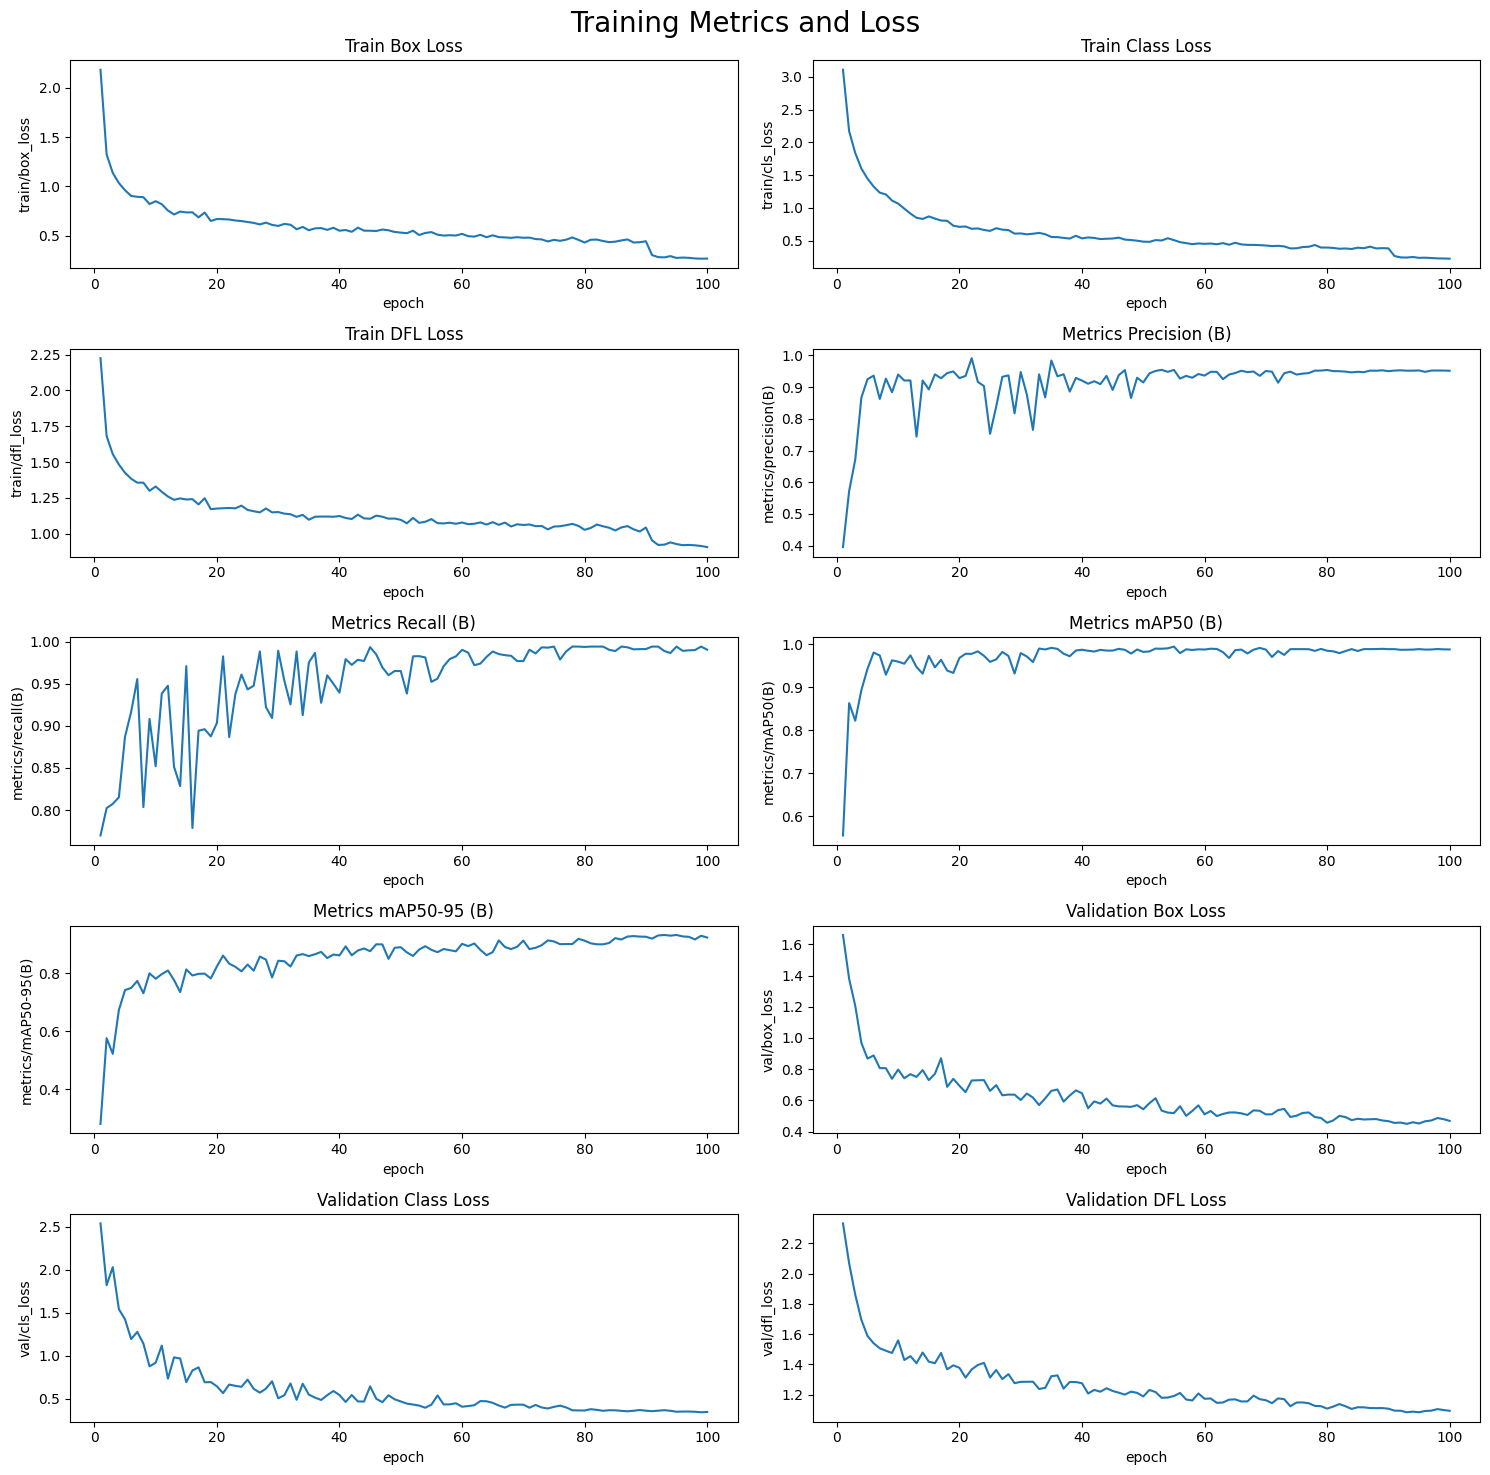

In [12]:
%matplotlib inline

df = pd.read_csv('/content/runs/detect/train/results.csv')                        # YOLO 학습에 따라 results.csv에 결과 저장됨 # 불러와 활용
df.columns = df.columns.str.strip()                                               # 컬럼 정보 불러와 (Header) 공백 제거

# create subplot
fig, axs = plt.subplots(nrows=5, ncols=2, figsize=(15,15))                        # 5행 2열
sns.lineplot(x='epoch', y='train/box_loss', data=df, ax=axs[0,0])
sns.lineplot(x='epoch', y='train/cls_loss', data=df, ax=axs[0,1])
sns.lineplot(x='epoch', y='train/dfl_loss', data=df, ax=axs[1,0])
sns.lineplot(x='epoch', y='metrics/precision(B)', data=df, ax=axs[1,1])
sns.lineplot(x='epoch', y='metrics/recall(B)', data=df, ax=axs[2,0])
sns.lineplot(x='epoch', y='metrics/mAP50(B)', data=df, ax=axs[2,1])
sns.lineplot(x='epoch', y='metrics/mAP50-95(B)', data=df, ax=axs[3,0])
sns.lineplot(x='epoch', y='val/box_loss', data=df, ax=axs[3,1])
sns.lineplot(x='epoch', y='val/cls_loss', data=df, ax=axs[4,0])
sns.lineplot(x='epoch', y='val/dfl_loss', data=df, ax=axs[4,1])

# set titles and axis labels for each subplot
axs[0,0].set(title='Train Box Loss')
axs[0,1].set(title='Train Class Loss')
axs[1,0].set(title='Train DFL Loss')
axs[1,1].set(title='Metrics Precision (B)')
axs[2,0].set(title='Metrics Recall (B)')
axs[2,1].set(title='Metrics mAP50 (B)')                                           # GT와 50% 겹친 경우 (실제로 사람의 눈으로 잘 찾았다 느껴지는 수준)
axs[3,0].set(title='Metrics mAP50-95 (B)')                                        # 엄격한 기준
axs[3,1].set(title='Validation Box Loss')
axs[4,0].set(title='Validation Class Loss')
axs[4,1].set(title='Validation DFL Loss')

# subheader title
plt.suptitle('Training Metrics and Loss', fontsize=20)

plt.subplots_adjust(top=0.8)
plt.tight_layout()
plt.show()

- mAP 관련 좋은 참고 자료
  - mAP & IoU 설명 : https://yunwoong.tistory.com/108
  - 좋은 설명 자료 : https://onesixx.com/meanap/
    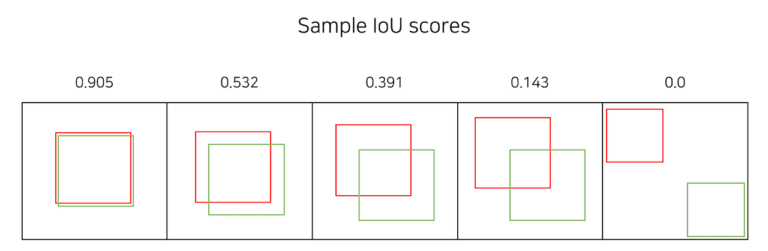
  - mAP : https://freddiekim.tistory.com/19
  - YOLO mAP 성능지표 설명 : https://darkpgmr.tistory.com/179

    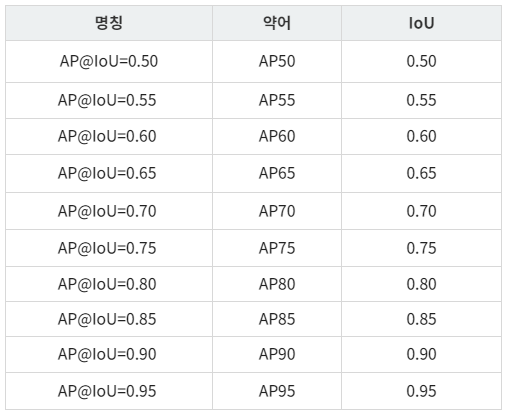

## Test

In [13]:
model = YOLO('/content/runs/detect/train/weights/best.pt')                        # 학습 결과 가장 잘 나온 파라미터로 YOLO 모델 설정해 Test 진행

In [14]:
results = model.predict(source=os.path.join('/content/furniture_detection-2','test','images'),save=True)  # test셋 경로에 있는 데이터를 넣어 예측


image 1/94 /content/furniture_detection-2/test/images/Chair-269-_jpg.rf.acc202ee7bd2d30964bcb23266e6ed13.jpg: 640x640 1 Chair, 9.3ms
image 2/94 /content/furniture_detection-2/test/images/Chair-270-_jpg.rf.fe443271ff8a3ef8f04a79574f23e7c6.jpg: 640x640 1 Chair, 16.6ms
image 3/94 /content/furniture_detection-2/test/images/Chairs-1-_jpg.rf.8b6ae0d90fadfcbbd1f663ed97483d6f.jpg: 640x640 1 Chair, 12.7ms
image 4/94 /content/furniture_detection-2/test/images/Chairs-10-_jpg.rf.465a289363064d0b7541e932ca22c8e0.jpg: 640x640 1 Chair, 11.2ms
image 5/94 /content/furniture_detection-2/test/images/Chairs-11-_jpg.rf.ea67306d49996d904a6baadba6eb6c6d.jpg: 640x640 1 Chair, 9.3ms
image 6/94 /content/furniture_detection-2/test/images/Chairs-15-_jpg.rf.ba100dd041ba9e0fbd5b2956109041b5.jpg: 640x640 1 Chair, 11.1ms
image 7/94 /content/furniture_detection-2/test/images/Chairs-16-_jpg.rf.81d012404f3871dd191251f92bc2fc35.jpg: 640x640 1 Chair, 10.9ms
image 8/94 /content/furniture_detection-2/test/images/Chairs-17-

In [15]:
metrics = model.val(conf=0.25, split='test')                                      # 모델이 예측한 모든 Bounding Box에서 예측한 Bounding Box 안에 객체가 있다 믿는 확률이 0.25로 성능 측정 (예측 기본 threshold 0.25)

Ultralytics YOLOv8.2.22 🚀 Python-3.10.12 torch-2.3.0+cu121 CUDA:0 (Tesla T4, 15102MiB)


val: Scanning /content/furniture_detection-2/test/labels... 94 images, 0 backgrounds, 0 corrupt: 100%|██████████| 94/94 [00:00<00:00, 1474.17it/s]

val: New cache created: /content/furniture_detection-2/test/labels.cache



                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:04<00:00,  1.32it/s]


                   all         94         94      0.989          1      0.995      0.954
                 Chair         94         50      0.967          1      0.995      0.978
                  Sofa         94         31          1          1      0.995      0.947
                 Table         94         13          1          1      0.995      0.936
Speed: 0.7ms preprocess, 11.0ms inference, 0.0ms loss, 11.5ms postprocess per image
Results saved to runs/detect/val


- 결과
  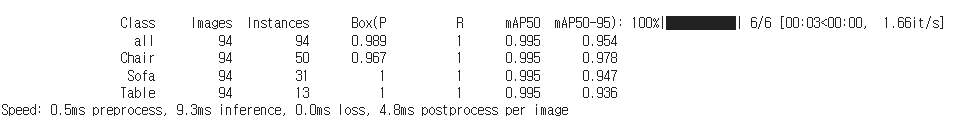

- mAP : 95.4 %

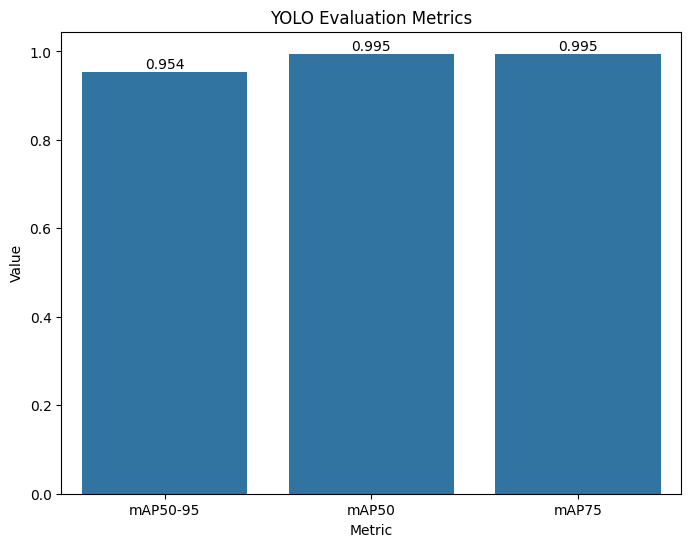

In [16]:
%matplotlib inline

# 예측 Bounding Box와 실제 Bounding Box의 중첩률(IoU) 기준 @mAP50-95, @mAP 50, @mAP75의 성능은 아래 barplot 결과와 같음
ax = sns.barplot(x=['mAP50-95','mAP50','mAP75'], y=[metrics.box.map, metrics.box.map50, metrics.box.map75])

# Set title
ax.set_title('YOLO Evaluation Metrics')
ax.set_xlabel('Metric')
ax.set_ylabel('Value')

# Set figure size
fig = plt.gcf()
fig.set_size_inches(8,6)

# 소숫점 3째 자리까지만 표시
for p in ax.patches:
    ax.annotate('{:.3f}'.format(p.get_height()), (p.get_x() + p.get_width() / 2, p.get_height()), ha='center', va='bottom')

plt.show()

In [17]:
import matplotlib.image as mpimg    # 이미지 시각화 위한 라이브러리 임포트

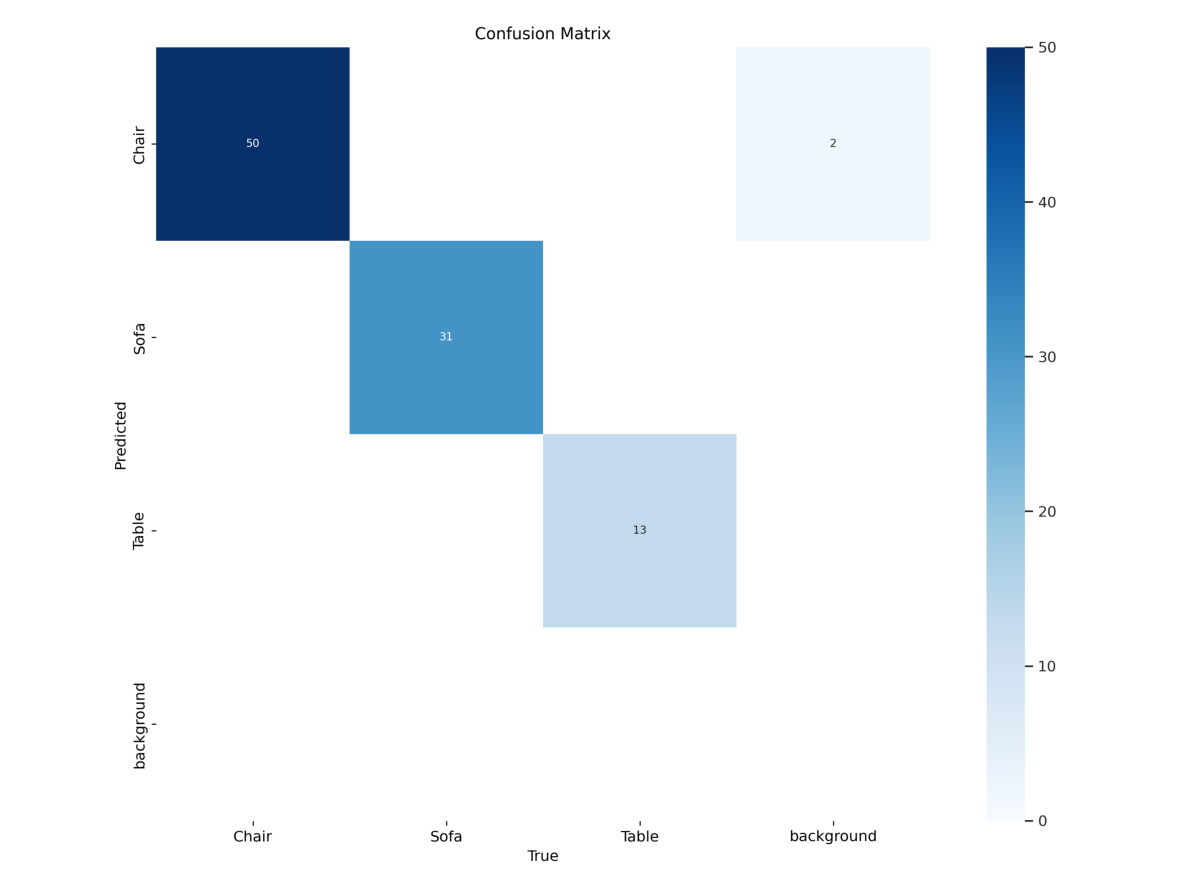

In [18]:
%matplotlib inline

# confusion matrix 결과
img = mpimg.imread('/content/runs/detect/val/confusion_matrix.png')

fig, ax = plt.subplots(figsize=(15,15))
ax.imshow(img)
ax.axis('off');

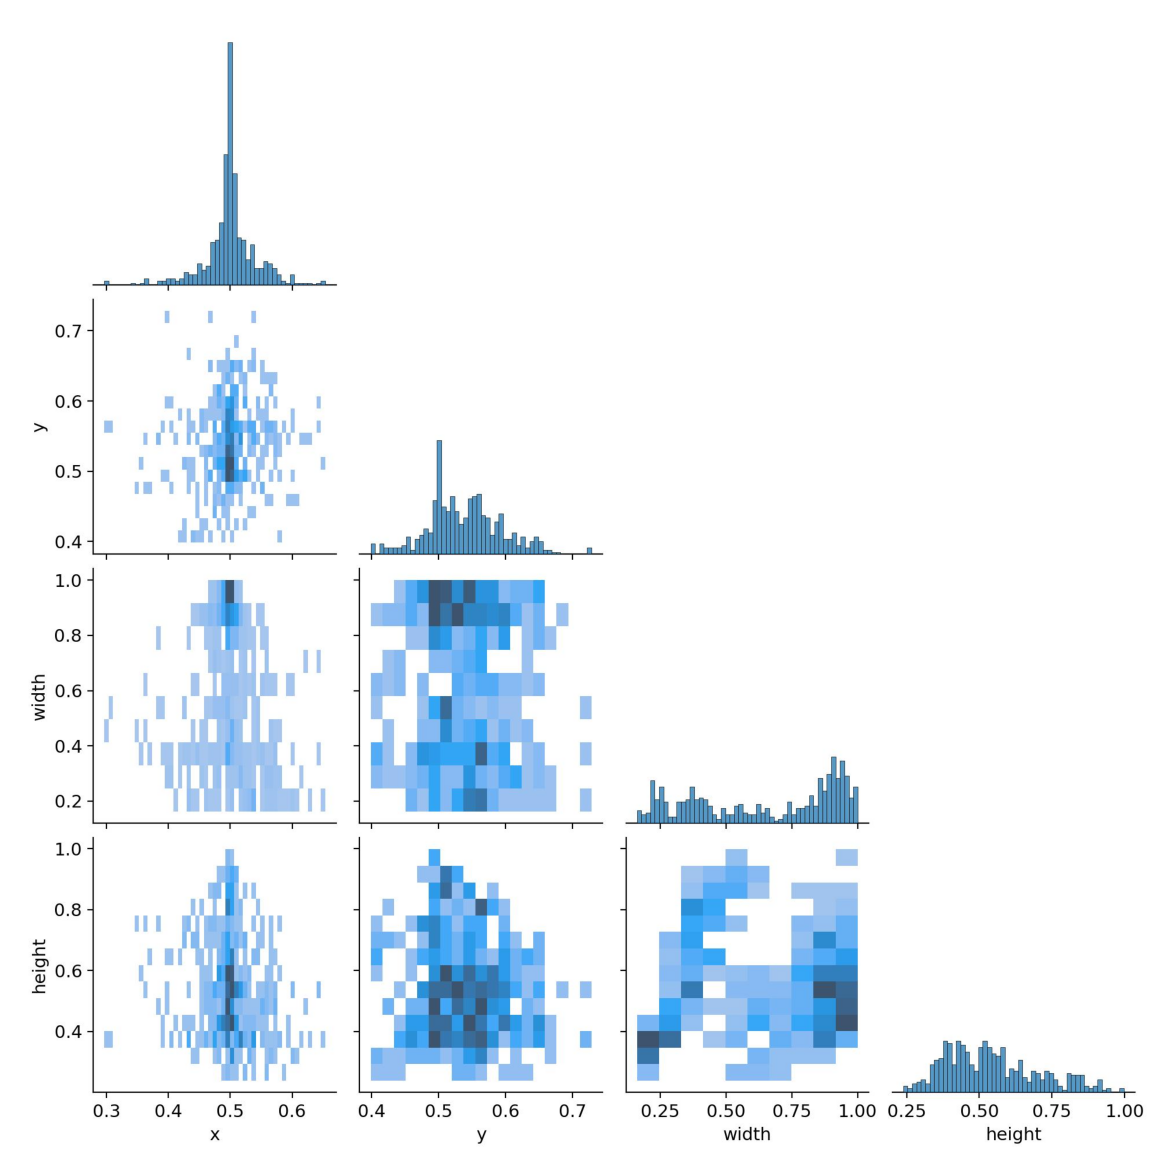

In [19]:
%matplotlib inline

# 학습 데이터셋의 correlogram (각 축에서의 분포 확인)
img = mpimg.imread('/content/runs/detect/train/labels_correlogram.jpg')

fig, ax = plt.subplots(figsize=(15,15))
ax.imshow(img)
ax.axis('off');

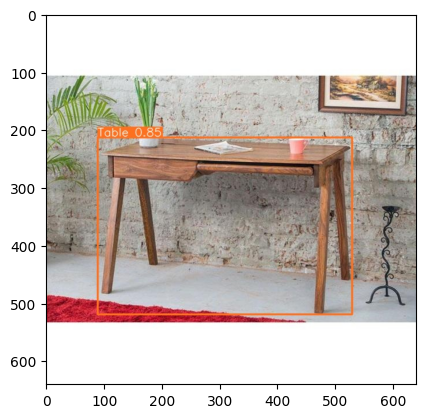

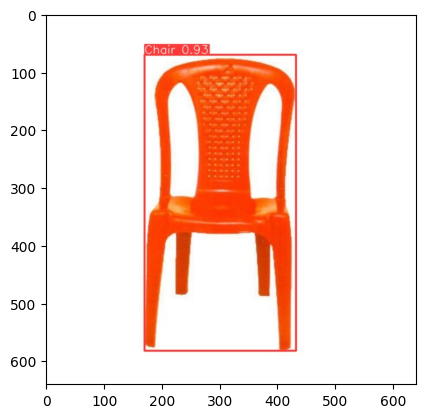

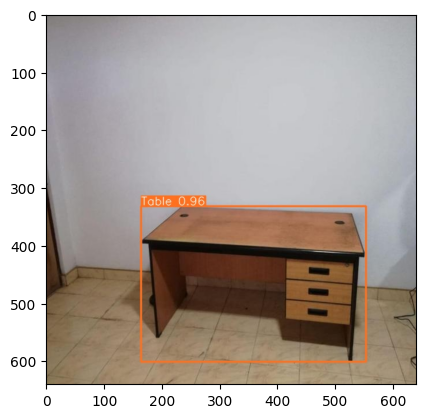

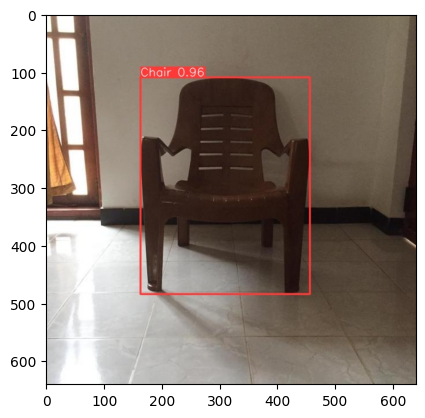

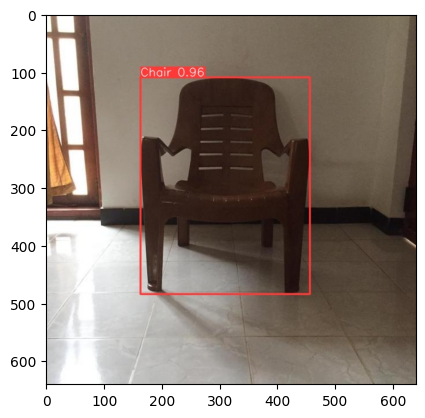

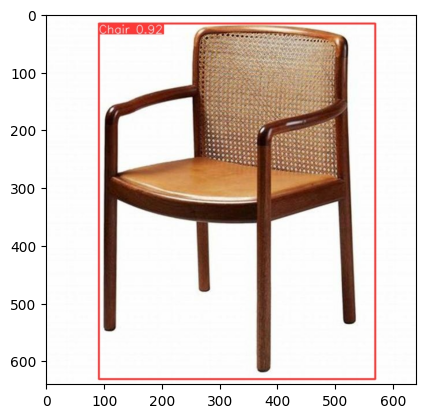

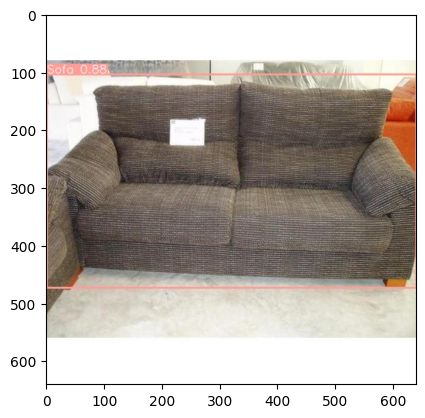

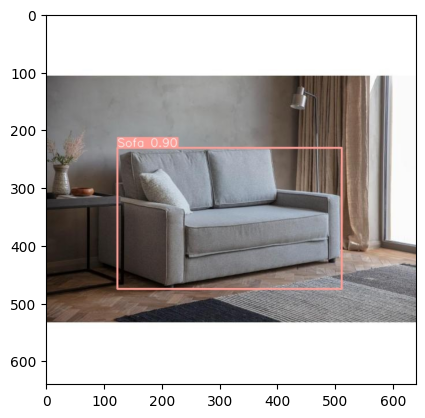

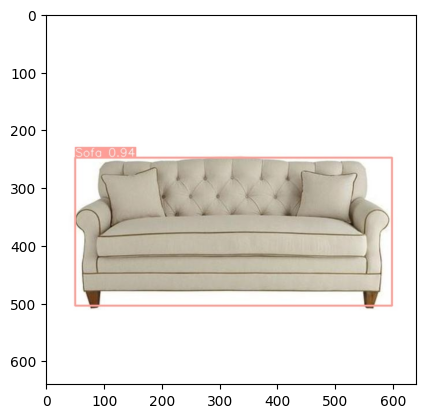

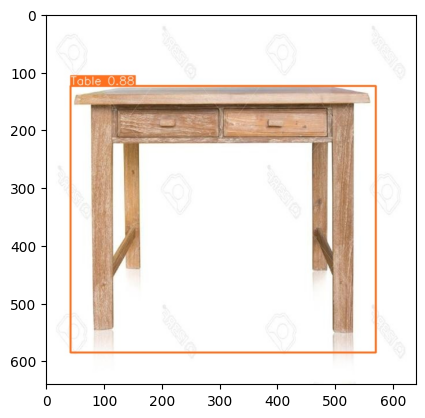

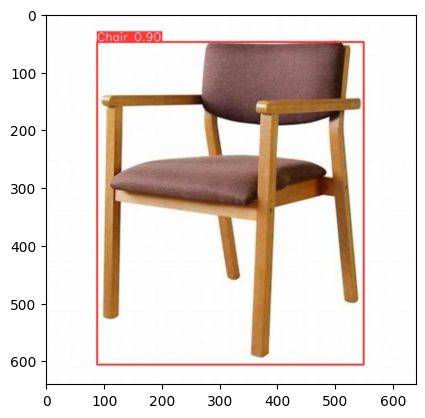

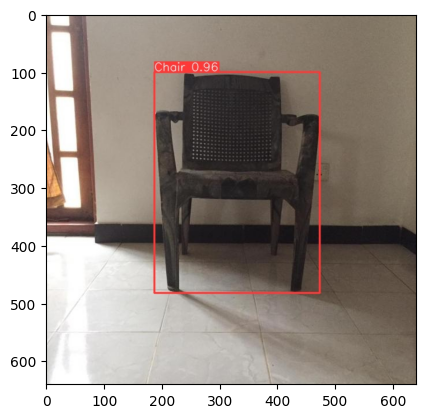

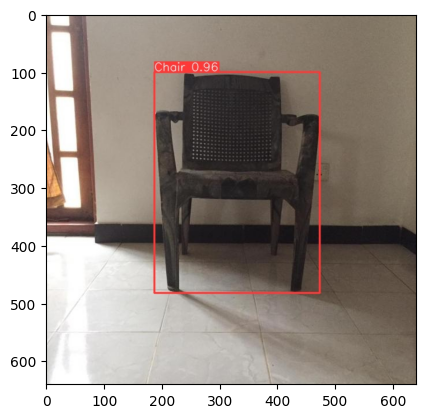

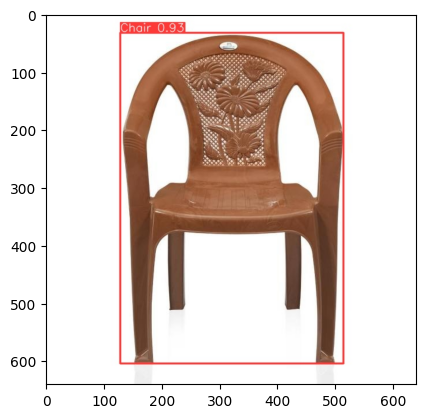

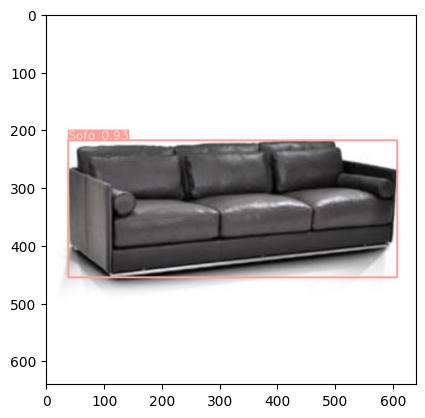

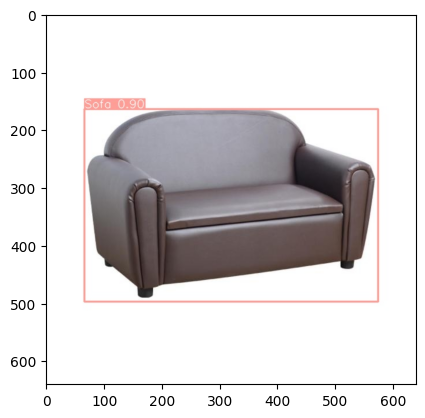

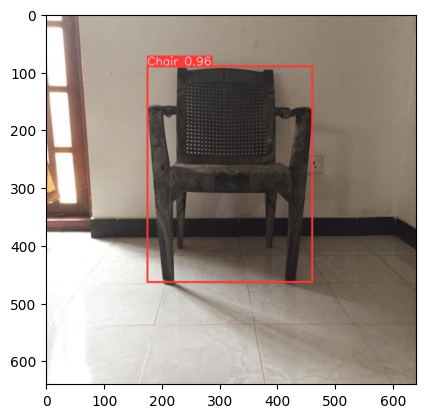

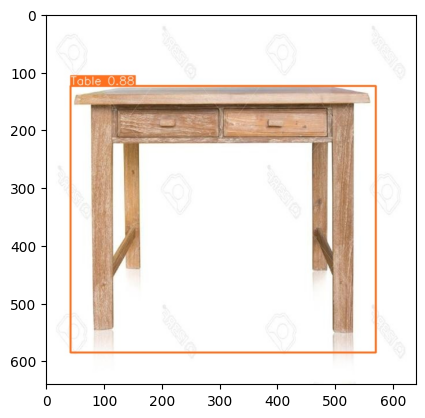

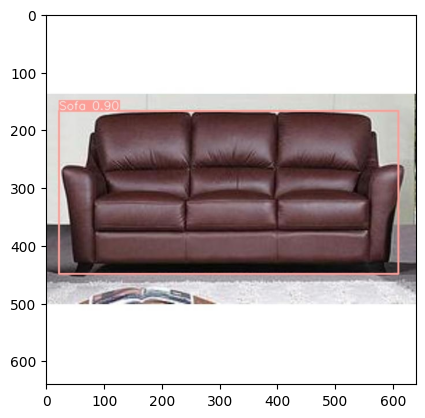

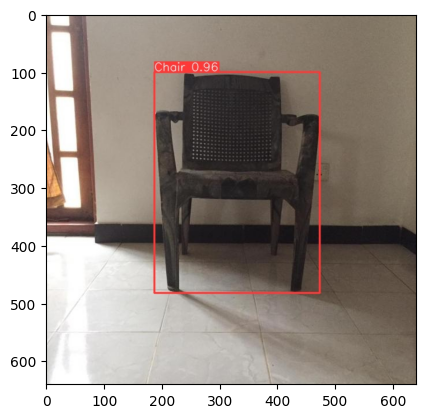

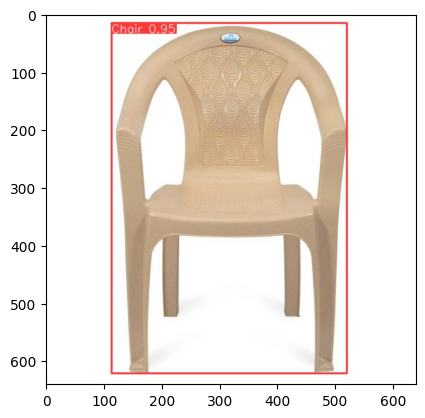

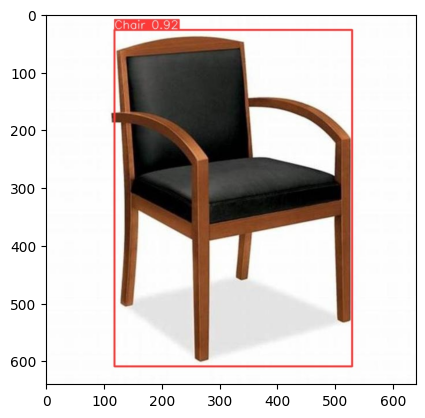

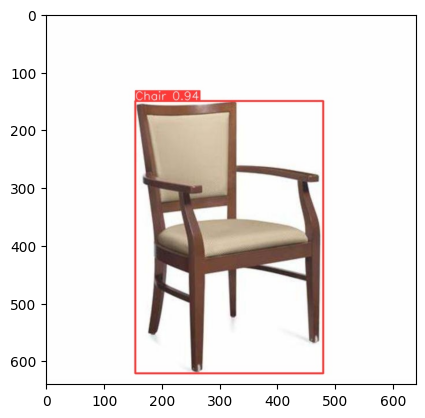

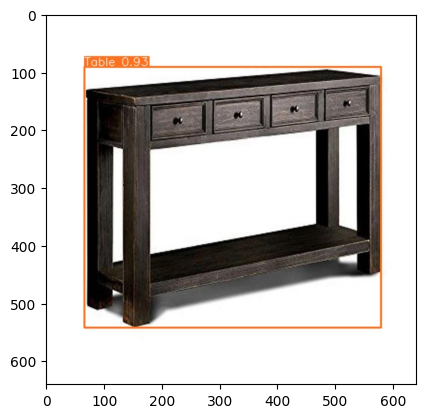

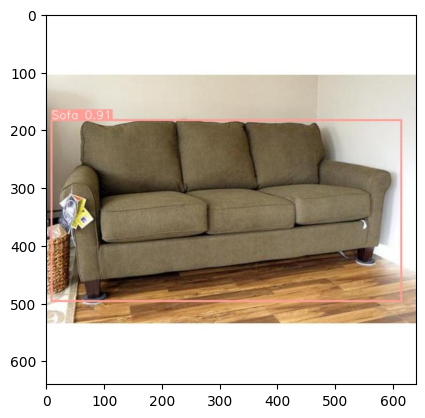

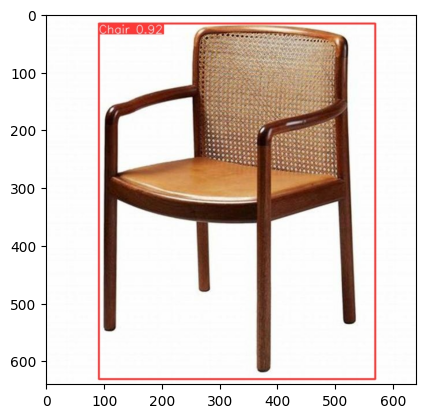

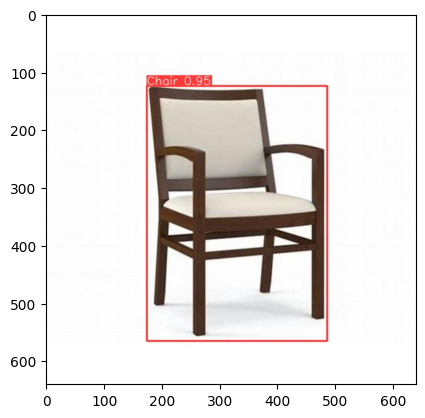

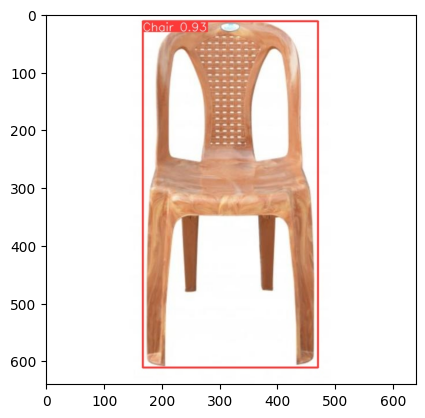

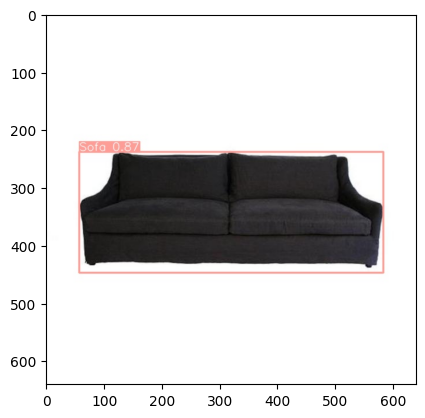

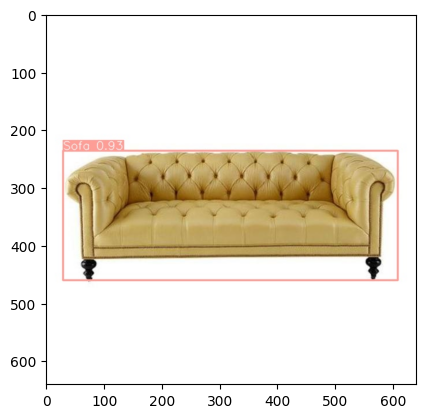

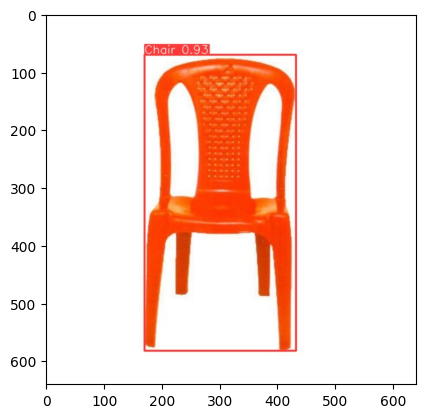

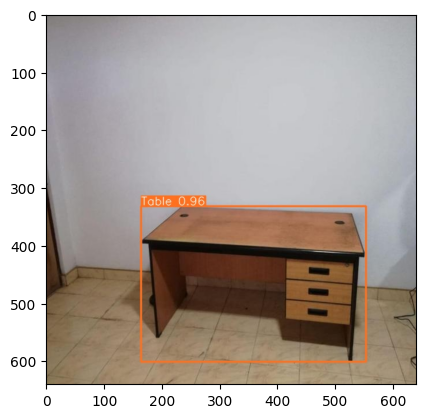

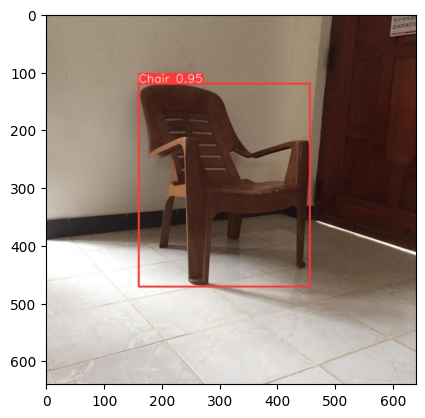

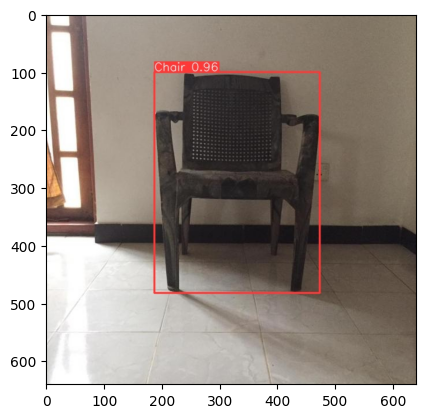

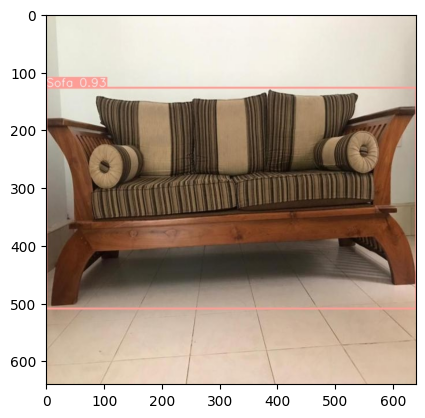

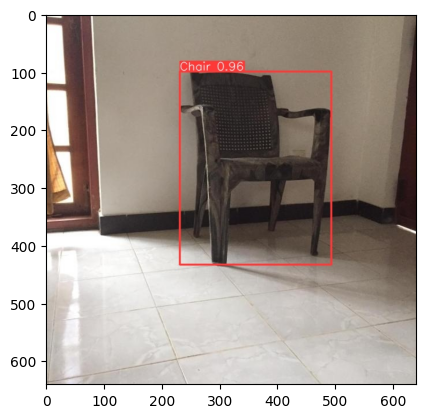

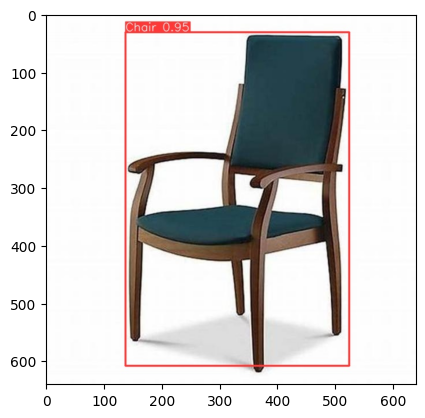

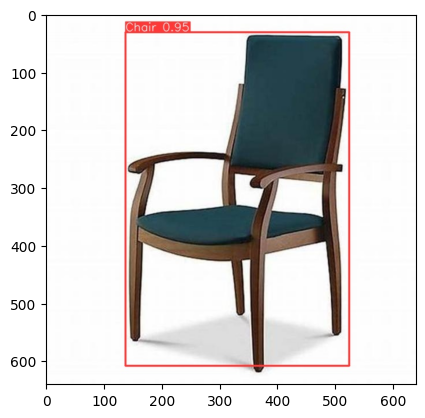

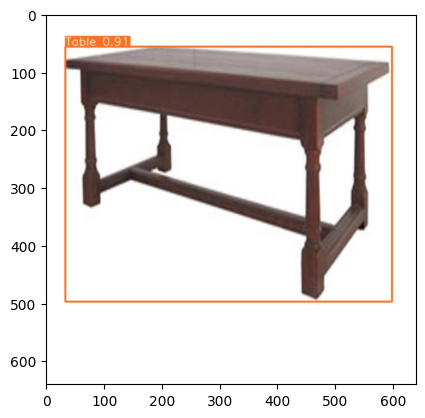

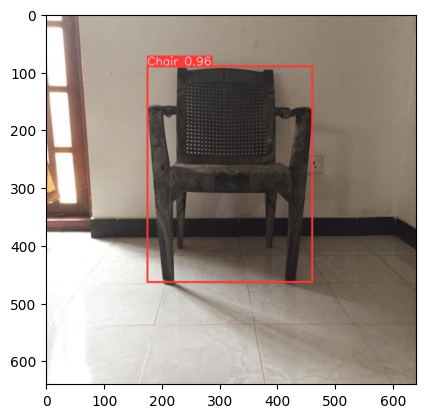

In [20]:
%matplotlib inline

# 예측 내용 확인해보기 (40번까지만 반복해 확인)
predicitions = glob.glob(os.path.join('/content/runs/detect/predict', '*'))

n = 40

for i in range(n):
    idx = np.random.randint(0, len(predicitions))
    image = Image.open(predicitions[idx])
    plt.imshow(image)
    plt.grid(False)
    plt.show()